## 1. Spatial sensitivity analysis of DSSAT model related to soil inputs

In [2]:
# !apt-get install -y  libhdf5-serial-dev netcdf-bin libnetcdf-dev

In [3]:
!pip -q install zarr
!pip -q install xarray[complete]
!pip -q install rioxarray
!pip -q install geopandas
!pip3 -q install aiohttp
!pip3 -q install gdown
!pip3 -q install salib
!pip -q install contextily
!pip -q install DSSATTools

import python packages

In [27]:
from DSSATTools import (
    Crop,
    SoilProfile,
    Weather,
    Management,
    available_cultivars,
)

from DSSATTools import DSSAT
import pandas as pd
from datetime import datetime
import numpy as np
import os
import datetime as dt
import requests
import math
import contextily as cx
import xarray as xr
from rosetta import rosetta, SoilData
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np

from SALib.test_functions import Ishigami
from SALib import ProblemSpec
from tqdm import tqdm_notebook


import fsspec
import xarray as xr
import rioxarray
import geopandas as gpd
import requests

from dask.diagnostics import ProgressBar
ProgressBar().register()

In [6]:


class DSSATModel:
    def __init__(self, ds_weather: xr.Dataset, ds_solar: xr.Dataset) -> None:
        self.ds_weather = ds_weather
        self.ds_solar = ds_solar

        self.MJ_to_J = lambda x: x * 1e6
        self.mm_to_cm = lambda x: x / 10.0
        self.K_to_C = lambda x: x - 273.15
        # self.tdew_to_hpa = lambda x: ea_from_tdew(x) * 10.0
        self.to_date = lambda d: d.date()
        self.HTTP_OK = 200
        self.kg_m2_to_mm = lambda x: x * 86400
        self.ms_to_kmd = lambda x: x * 86.4
        self.watt_to_joules = lambda x: x * 86400
        # To-do: add ALLSKY_SFC_PAR_TOT to weather

    def _csvdate_to_date(self, x, dateformat):
        """Converts string x to a datetime.date using given format.

        :param x: the string representing a date
        :param dateformat: a strptime() accepted date format
        :return: a date
        """
        dt_f = dt.datetime.strptime(str(x), dateformat)
        return dt_f

    def get_elevation(self, longitude: float, latitude: float) -> float:
        """_get_elevation
        Get elevation from OpenTopoData API by lon and lat

        Args:
            longitude (float): longitude in WGS84
            latitude (float): latitude in WGS84

        Returns:
            float: elevation (m)
        """
        url = (
            f"https://api.opentopodata.org/v1/aster30m?locations={latitude},{longitude}"
        )
        resp = requests.get(url=url, timeout=10)
        try:
            resp = requests.get(url=url, timeout=10)
            if resp.status_code == 200:
                data = resp.json()
                elevation = data["results"][0]["elevation"]
            else:
                elevation = 200
        except:
            elevation = 200
        return elevation
    def select_from_xarray(self, longitude: float, latitude: float) -> pd.DataFrame:
        """Select weather from Xarray dataset

        Args:
            longitude (float): point longitude
            latitude (float): point latitude

        Returns:
            pd.DataFrame: weather dataframe
        """
        point_weather = self.ds_weather.sel(
            lon=longitude, lat=latitude, method="nearest"
        )
        point_solar = self.ds_solar.sel(lon=longitude, lat=latitude, method="nearest")
        df_power = self.xr_dataset_to_pandas(ds=point_weather)

        df_solar = self.xr_dataset_to_pandas(ds=point_solar)

        df_power["DAY"] = pd.to_datetime(point_weather.time.values, format="%Y%m%d")

        df_solar = (
            df_solar.apply(self.watt_to_joules) / 1e6
        )  # Convert to MJ for A,B computing

        df_power = pd.concat([df_power, df_solar], axis=1)
        return df_power

    def xr_dataset_to_pandas(self, ds: xr.Dataset) -> pd.DataFrame:
        """Convert xarray point to pandas -> faster than implimented"""
        dict_to_pandas = {}
        for key in list(ds.keys()):
            dict_to_pandas[key] = ds[key].values
        return pd.DataFrame(dict_to_pandas)

    def get_dssat_weather(self, longitude: float, latitude: float):

        df_power = self.select_from_xarray(longitude=longitude, latitude=latitude)

        # Convert POWER data to a dataframe with PCSE compatible inputs
        df_dssat = pd.DataFrame(
            {
                "DATE": df_power.DAY.apply(self.to_date),
                "TMEAN": df_power.T2M.apply(self.K_to_C),
                "TMIN": df_power.T2M_MIN.apply(self.K_to_C),
                "TMAX": df_power.T2M_MAX.apply(self.K_to_C),
                "WIND": df_power.WS2M.apply(self.ms_to_kmd),
                "RAD": df_power.ALLSKY_SFC_SW_DWN,
                "RAIN": df_power.PRECTOTCORR.apply(self.kg_m2_to_mm),
                "DEWP": df_power.T2MDEW.apply(self.K_to_C),
                "RHUM": df_power.RH2M,
            }
        )
        df_dssat.loc[:, "DATE"] = df_dssat.loc[:, "DATE"].apply(
            lambda x: self._csvdate_to_date(x, "%Y-%m-%d")
        )
        self.df_dssat = df_dssat.reset_index(drop=True)
        return df_dssat

    def compute(
        self,
        crop_name: str,
        cultivar: str,
        lat: float,
        lon: float,
        harvest: datetime,
        sowing: datetime,
        soil,
        crop = None,
    ):

        df_weather = self.get_dssat_weather(latitude=lat, longitude=lon)
        df_weather["DATE"] = pd.to_datetime(df_weather["DATE"])
        weather_cols = ["DATE", "TMIN", "TMAX", "RAD", "RAIN", "RHUM"]
        wth = Weather(
            df_weather[weather_cols].copy(),
            pars={
                "DATE": "DATE",
                "TMIN": "TMIN",
                "TMAX": "TMAX",
                "RAIN": "RAIN",
                "RAD": "SRAD",
                "RHUM": "RHUM",
            },
            lat=lat,
            lon=lon,
            elev=self.get_elevation(latitude=lat, longitude=lon),
        )
        # soil = SoilProfile(default_class="SCL")
        if crop is None:
            crop = Crop(crop_name, cultivar)
        man = Management(planting_date=sowing, irrigation="A")

        man.harvest_details["HDATE"] = harvest.strftime("%y%j")
        man.harvest_details["HPC"] = 100

        #
        dssat = DSSAT()
        dssat.setup()

        dssat.run(
            soil=soil,
            weather=wth,
            crop=crop,
            management=man,
        )
        if "PlantGro" in dssat.output:  # type: ignore
            output_1 = dssat.output["PlantGro"]  # type: ignore
            dssat.close()
            return float(output_1["CWAD"].max())
        else:
            raise ValueError("DSSAT no output")
def clip_by_region(ds:xr.Dataset):
    gdf = gpd.read_file('https://raw.githubusercontent.com/leakyMirror/map-of-europe/master/GeoJSON/europe.geojson')
    gdf = gdf.set_crs('EPSG:4326')
    ds.rio.write_crs("epsg:4326", inplace=True)
    clipped = ds.rio.clip(gdf.geometry.values, gdf.crs)
    return clipped

## 1. Weather
----

Download weather from NASA POWER in NetCDF format

In [7]:

def clip_by_region(ds:xr.Dataset):
    gdf = gpd.read_file('https://raw.githubusercontent.com/leakyMirror/map-of-europe/master/GeoJSON/europe.geojson')
    gdf = gdf.set_crs('EPSG:4326')
    ds.rio.write_crs("epsg:4326", inplace=True)
    clipped = ds.rio.clip(gdf.geometry.values, gdf.crs)
    return clipped


def get_nasa_power_weather(date_start: str = '2022-01-01', date_end:str= '2022-12-31'):
    product = 'power_901_daily_meteorology_utc.zarr'
    
    solar_product = "power_901_daily_radiation_utc.zarr"
    
    filepath = f'https://power-analysis-ready-datastore.s3.amazonaws.com/{product}'
    
    filepath_mapped = fsspec.get_mapper(filepath)
    ds = xr.open_zarr(store=filepath_mapped, consolidated=True)
    
    filepath = f'https://power-analysis-ready-datastore.s3.amazonaws.com/{solar_product}'
    filepath_mapped = fsspec.get_mapper(filepath)
    ds_solar = xr.open_zarr(store=filepath_mapped, consolidated=True)
    solar_variables = ["TOA_SW_DWN",
             "ALLSKY_SFC_SW_DWN"]

    weather_variables = ["T2M",
                 "T2M_MIN",
                 "T2M_MAX",
                 "T2MDEW",
                 "WS2M",
                 "PRECTOTCORR",
                 "RH2M"]
    
    ds_solar = ds_solar[solar_variables]
    ds = ds[weather_variables]
    ds_eu = clip_by_region(ds=ds)
    ds_eu_solar = clip_by_region(ds=ds_solar)

    year = 2022
    ds_eu_year=ds_eu.sel(time=slice(date_start, date_end))
    ds_eu_solar_year=ds_eu_solar.sel(time=slice(date_start, date_end))
    ds_eu_year.load()
    ds_eu_solar_year.load()
    return {"weather": ds_eu_year, "solar": ds_eu_solar_year}

In [8]:
weather = get_nasa_power_weather(date_start='2022-01-01', date_end='2023-12-31')

/usr/local/lib/python3.7/dist-packages/xarray/backends/plugins.py:68: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


[########################################] | 100% Completed |  2min 41.2s
[########################################] | 100% Completed |  2min  1.4s


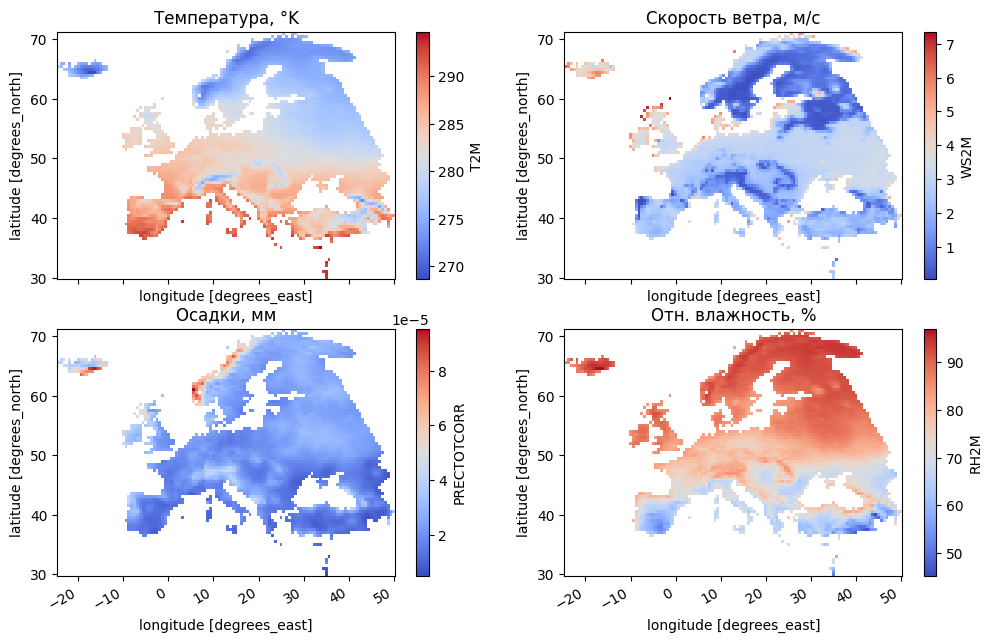

In [11]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2,ncols=2, figsize=(12,8))
fig.autofmt_xdate()

target_plots = ["T2M",
             "WS2M",
             "PRECTOTCORR",
             'RH2M']

target_names = ["Temperature, °K",
             "Wind speed, m/s",
             "Rain, mm",
             'Rel. hunidity, %']


target_names = ["Температура, °K",
             "Скорость ветра, м/с",
             "Осадки, мм",
             'Отн. влажность, %']
for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    select = weather['weather'].sel(time=slice('2022-01-01', '2022-12-31'))
    (select.mean(dim='time')[target_plots[i]]).plot(ax=ax, cmap='coolwarm')
    ax.set_title(target_names[i])
plt.savefig('../plots/nasa_eu.png', dpi=300)

## 2. Agrotechnology from Crop Sage Dataset

-----

Source - https://sage.nelson.wisc.edu/data-and-models/datasets/crop-calendar-dataset/

Version - 0.5 degree unfilled for winter wheat

In [7]:
# !gdown 1TT1zf1jjQ6Jf8c2phy1mPKqhXcZ8mVsG
# !gzip -d Soybeans.crop.calendar.fill.nc.gz

In [22]:
class Agrotechnology:
    """
    TO-DO:
    1. Add: major agrotech info for DSSAT, MONICA and WOFOST
    2. AWS: add reading files from AWS S3 storage or from source Drive files (archive?)
    """

    def __init__(self,crop:str, pathCalendar: str='./') -> None:

        self.pathCalendar = pathCalendar
        self.dictCalendars = {
            "barley": "Barley.crop.calendar.fill.nc",
            "soybean": "Soybeans.crop.calendar.nc",
            "sunflower": "Sunflower.crop.calendar.fill.nc",
            "maize": "Maize.crop.calendar.fill.nc",
            "wheat": "Wheat.Winter.crop.calendar.nc",
        }
        self.dataset=xr.open_dataset(os.path.join(pathCalendar,self.dictCalendars[crop] ))

    def getCropCalendar(
        self, lon: float, lat: float, year: str = "2022"
    ) -> dict:

        harvest_flt = float(
            self.dataset.sel(latitude=lat, longitude=lon, method="nearest").harvest.values
        )
        plant_flt = float(
            self.dataset.sel(latitude=lat, longitude=lon, method="nearest").plant.values
        )
        if (math.isnan(harvest_flt)) or (math.isnan(plant_flt)):
            return {"plant_day": "NaN", "harvest_day": "NaN"}
        harvest_day = str(
            dt.datetime.strptime(f"{year} {int(harvest_flt)}", "%Y %j").date()
        )
        plant_day = str(
            dt.datetime.strptime(f"{year} {int(plant_flt)}", "%Y %j").date()
        )

        if harvest_day < plant_day:
            plant_day = plant_day.replace(str(year), str(year-1))
        return {"plant_day": dt.datetime.strptime(plant_day, '%Y-%m-%d'),
                "harvest_day": dt.datetime.strptime(harvest_day, '%Y-%m-%d')}


In [23]:
agrocalendar = Agrotechnology(crop='wheat', pathCalendar='../examples/')

In [24]:
agrocalendar.getCropCalendar(lon=5, lat=45, year = 2023)

{'plant_day': datetime.datetime(2022, 10, 30, 0, 0),
 'harvest_day': datetime.datetime(2023, 7, 31, 0, 0)}

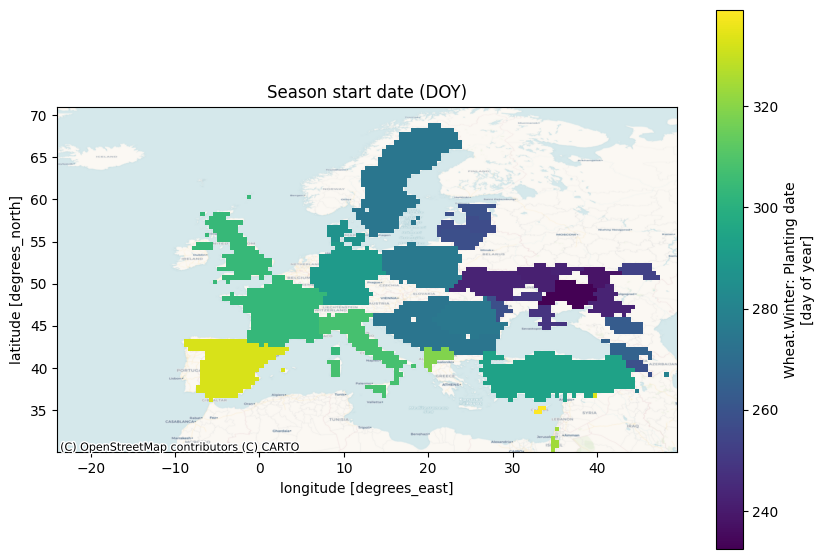

In [29]:
fig, ax = plt.subplots(figsize=(10, 7))
ds_plant = agrocalendar.dataset
gdf = gpd.read_file('https://raw.githubusercontent.com/leakyMirror/map-of-europe/master/GeoJSON/europe.geojson')
gdf = gdf.set_crs('EPSG:4326')
ds_plant.rio.write_crs("epsg:4326", inplace=True)
clipped = ds_plant['plant'].rio.clip(gdf.geometry.values, gdf.crs)
clipped.plot(ax=ax)
ax.set_title("Season start date (DOY)")
cx.add_basemap(ax, crs="epsg:4326", source=cx.providers.CartoDB.Voyager)
plt.savefig('../plots/start_season.png', dpi=300)

## 3. Soil data

In [32]:
from pandas import isna

class SoilSA:
    def __init__(self):
        self.df_eu = pd.read_csv('../examples/soil_coords_eu.csv')
        self.eu_list = self.df_eu.values.tolist()
        self.folder = '/mnt/bulky2/mgasanov/DSSAT/dataverse_files/SoilGrids-for-DSSAT-10km v1.0 (by country)/'
        self.nodes = np.hstack((self.df_eu[['X']].values,self.df_eu[['Y']].values))
    def van_genuchten(self, theta_r, theta_s, alpha, n, h):
        '''
        Van Genuchten function for soil water retention. Returns theta for a given h (kPa)
        
        Arguments
        ----------
        theta_r: float
            residual water content
        theta_s: float
            saturated water content
        log10(alpha): float
            van Genuchten 'alpha' parameter (1/cm)
        log10(n): float
            van Genuchten 'n' parameter
        '''
        alpha = 10**alpha 
        n = 10**n
        m = 1 - 1/n 
        theta = theta_r + (theta_s - theta_r)/(1 + abs(alpha * h)**n)**m
        return theta

    def aggregate_top_layer(self, soil):
        # top_layer = pd.DataFrame()
        # to_drop = []
        for depth in list(soil.layers.keys()):
            if depth < 30:
                # top_layer = pd.concat([top_layer, soil.layers[depth]], axis=1)
                soil.layers.pop(depth)
        # top_layer=top_layer.mean(axis=1)
        # top_layer.iloc[0] = 30
        # soil.layers[30] = top_layer
        # soil.layers[30] = soil.layers[30].fillna(soil.layers[90]['SLMH'])
        # soil.layers = dict(sorted(soil.layers.items()))
        soil.n_layers = len(soil.layers)
        return soil 

    def estimate_missing(self, soil_layer):
            # Soil Hydraulic parameters are estimated from van_genuchten equation's parameters.
            # Those parameters are estimated using Pedo-Transfer Funcitons (PTF). For this case
            # USDA rosetta model (Zhang et al., 2017) was used. doi: 10.1016/j.jhydrol.2017.01.004
            if isna(soil_layer.SBDM):
                soil_data = SoilData.from_array(
                    [[100 - soil_layer.SLCL - soil_layer.SLSI, soil_layer.SLSI, soil_layer.SLCL]]
                )
                vangenuchten_pars, _, _ = rosetta(2, soil_data)
                # Calculate SBDM
            else:
                soil_data = SoilData.from_array(
                    [[100 - soil_layer.SLCL - soil_layer.SLSI, soil_layer.SLSI, soil_layer.SLCL, soil_layer.SBDM]]
                )
                vangenuchten_pars, _, _ = rosetta(3, soil_data)
    
            vangenuchten_pars = vangenuchten_pars[0]
            soil_layer.SSAT = vangenuchten_pars[1]
            soil_layer.SSKS = (10**vangenuchten_pars[-1]) / 24
            soil_layer.SLLL = self.van_genuchten(*vangenuchten_pars[:-1], h=1500)
            soil_layer.SDUL = self.van_genuchten(*vangenuchten_pars[:-1], h=33)     
        
            if isna(soil_layer.SLOC):
                soil_layer.SLOC = color_to_oc(soil_layer.SCOM)
                soil_layer.SBDM = 1.386 - 0.078*soil_layer.SLOC + 0.001*soil_layer.SLSI + 0.001*soil_layer.SLCL
            else:
                soil_layer.SBDM = 1.72 - 0.294*soil_layer.SLOC**0.5
            
            if isna(soil_layer.SLOC): soil_layer.SLOC = color_to_oc(soil_layer.SCOM)
                
            return soil_layer

    def closest_node(self, node, nodes):
        nodes = np.asarray(nodes)
        deltas = nodes - node
        dist_2 = np.einsum('ij,ij->i', deltas, deltas)
        return np.argmin(dist_2)
    def get_soil_by_coords(self, lon, lat):
        node = [lon, lat] ##weather pointt
        # nodes = np.hstack((self.df_eu[['X']].values,self.df_eu[['Y']].values))
        node_idx = self.closest_node(node, self.nodes)
        soil_profile_number,soil_profile_country = self.eu_list[node_idx][2:4]
        # soil_profile_number = self.eu_list[node_idx][2]
        # soil_profile_country = self.eu_list[node_idx][3]
        dr = os.path.join(self.folder, str(soil_profile_country)+'.SOL')
        soilprofile = SoilProfile(
            file=dr,
            profile = soil_profile_number)
        return soilprofile

soil_sa = SoilSA()

## 4. Compute wheat crop yield for Europe

In [33]:
dssat_runner = DSSATModel(ds_weather = weather['weather'], 
                          ds_solar = weather['solar'])

In [34]:
container = []
ds_eu = weather['weather']
ds_solar = weather['solar']
year = 2023
for lat in tqdm_notebook(ds_eu.lat.values):
    for lon in ds_eu.lon.values:
        point_weather = dssat_runner.ds_weather.sel(lon=lon, lat=lat, method="nearest")
        if point_weather['T2M'].sum().values==0:
            container.append(
                    {
                        "lon": lon,
                        "lat": lat,
                        "Yield": np.nan,
                        "Problem": "no weather available",
                    }
                )
            continue
        calendar= agrocalendar.getCropCalendar(lon=lon, lat=lat, year = year)
        if calendar['plant_day'] == 'NaN':
            container.append(
                    {
                        "lon": lon,
                        "lat": lat,
                        "Yield": np.nan,
                        "Problem": "no agro calendar available",
                    }
                )
            continue
        try: 
            start = time.time()
            soil = soil_sa.get_soil_by_coords(lon=lon, lat=lat)
        except KeyboardInterrupt as e:
            print('Interrupted')
            try:
                sys.exit(130)
            except SystemExit:
                os._exit(130)
        except Exception as e:
            soil = SoilProfile(default_class='SCL')
#             soil = soil_sa.get_soil_by_coords(lon=41.1, lat=49.9)
    

        try:
            crop_yield = dssat_runner.compute(
                crop_name="wheat",
                cultivar="IB1500",
                lat=lat,
                lon=lon,
                harvest=calendar["harvest_day"],
                sowing=calendar["plant_day"],
                soil=soil)
            container.append(
                {"lon": lon, "lat": lat, "Yield": crop_yield, "Problem": "OK"}
            )
        except Exception as e:
            container.append(
                {"lon": lon, "lat": lat, "Yield": np.nan, "Problem": e}
            )
            continue

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/83 [00:00<?, ?it/s]

/tmp/dssathtqggesb created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1  89 122  3484  1626    70    49   192   123     0   -99      0  158
/tmp/dssathtqggesb and its content has been removed.
/tmp/dssatsobdojzc created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1  87 118  3222  1511   149    24   233   135     0   -99      0  158
/tmp/dssatsobdojzc and its content has been removed.
/tmp/dssatcchncfxd created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1  86 117  3217  1485   152    24   223   148     0   -99      0  158
/tmp/dssatcchncfxd and its content has been removed.
/tmp/dssatqhxopwiw created.

RUN    TRT FLO

/tmp/dssatcuhjjvhw created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 199 235  1257   663   326     0   416    87     0   -99      0  158
/tmp/dssatcuhjjvhw and its content has been removed.
/tmp/dssatezumzhav created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 150 201  1654   606   254     0   326   124     0   -99      0  158
/tmp/dssatezumzhav and its content has been removed.
/tmp/dssatafjejaat created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1  77 129  2386   727   160     0   192   165     0   -99      0  158
/tmp/dssatafjejaat and its content has been removed.
/tmp/dssatgseqpnxd created.

RUN    TRT FLO

/tmp/dssatseydisnm created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 149 200  1697   619   418     0   370   145     0   -99      0  158
/tmp/dssatseydisnm and its content has been removed.
/tmp/dssatarfardrt created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 134 190  1685   588   377     0   340   139     0   -99      0  158
/tmp/dssatarfardrt and its content has been removed.
/tmp/dssatoikfivna created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 165 211  1677   699   460     0   414   127     0   -99      0  158
/tmp/dssatoikfivna and its content has been removed.
/tmp/dssatqhzzfvvr created.

RUN    TRT FLO

/tmp/dssatjjsulhop created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1  97 128  1276   682   190    24   188   130     0   -99      0  158
/tmp/dssatjjsulhop and its content has been removed.
/tmp/dssatohklogba created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1  97 128  1219   656   176    24   183   125     0   -99      0  158
/tmp/dssatohklogba and its content has been removed.
/tmp/dssatnmflrhkx created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 100 131  1199   609   140    25   158   135     0   -99      0  158
/tmp/dssatnmflrhkx and its content has been removed.
/tmp/dssatjzcuaqdj created.

RUN    TRT FLO

/tmp/dssatugirhwmw created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 154 198  1236   494   438     0   329   147     0   -99      0  158
/tmp/dssatugirhwmw and its content has been removed.
/tmp/dssatnfhpeajb created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 144 187  1439   656   398     0   296   166     0   -99      0  158
/tmp/dssatnfhpeajb and its content has been removed.
/tmp/dssatjmodeweo created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 135 177  1648   748   361     0   253   192     0   -99      0  158
/tmp/dssatjmodeweo and its content has been removed.
/tmp/dssattjuctvuk created.

RUN    TRT FLO

/tmp/dssatyuzvimqm created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 165 209  1592   644   267     0   364    97     0   -99      0  158
/tmp/dssatyuzvimqm and its content has been removed.
/tmp/dssatukanzrva created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 155 201  1496   605   159    24   269   108     0   -99      0  158
/tmp/dssatukanzrva and its content has been removed.
/tmp/dssatabjsmalk created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 155 201  1521   636   157    24   262   113     0   -99      0  158
/tmp/dssatabjsmalk and its content has been removed.
/tmp/dssatnywuxyka created.

RUN    TRT FLO

/tmp/dssatkcbzgklw created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 112 143  1212   575   134    49   168   135     0   -99      0  158
/tmp/dssatkcbzgklw and its content has been removed.
/tmp/dssatgqfulswd created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 114 146  1208   570   109    49   155   138     0   -99      0  158
/tmp/dssatgqfulswd and its content has been removed.
/tmp/dssatlwrqpjwl created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 119 151  1158   544   122    49   164   134     0   -99      0  158
/tmp/dssatlwrqpjwl and its content has been removed.
/tmp/dssatoygqsyqy created.

RUN    TRT FLO

/tmp/dssatqnzmlknz created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 185 223  1159   520   529     0   416   161     0   -99      0  158
/tmp/dssatqnzmlknz and its content has been removed.
/tmp/dssatoylnsgqg created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 204 235   657   320   633     0   442   136     0   -99      0  158
/tmp/dssatoylnsgqg and its content has been removed.
/tmp/dssatwinczcyv created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 221 251    89    45   665     0   441   125     0   -99      0  158
/tmp/dssatwinczcyv and its content has been removed.
/tmp/dssatzeoepjem created.

RUN    TRT FLO

/tmp/dssatxgoknhqv created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 123 174  1448   497   369     0   246   213     0   -99      0  158
/tmp/dssatxgoknhqv and its content has been removed.
/tmp/dssatixfspftf created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 139 195  1474   476   346     0   319   161     0   -99      0  158
/tmp/dssatixfspftf and its content has been removed.
/tmp/dssatoknbwswf created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 150 203  1388   485   306     0   331   152     0   -99      0  158
/tmp/dssatoknbwswf and its content has been removed.
/tmp/dssattdrgslaf created.

RUN    TRT FLO

/tmp/dssatsdjfwgcx created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 174 214  1520   727   152    24   295    77     0   -99      0  158
/tmp/dssatsdjfwgcx and its content has been removed.
/tmp/dssatksbazsrh created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 210 254  2571  1155   194    49   339   100     0   -99      0  158
/tmp/dssatksbazsrh and its content has been removed.
/tmp/dssatfypbkebf created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 110 145  1089   485   456     0   202   134     0   -99      0  158
/tmp/dssatfypbkebf and its content has been removed.
/tmp/dssatpbbapmwu created.

RUN    TRT FLO

/tmp/dssatbcumsftn created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 172 216  1392   544   350     0   375   150     0   -99      0  158
/tmp/dssatbcumsftn and its content has been removed.
/tmp/dssatljotgucu created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 187 227  1389   611   375     0   420   134     0   -99      0  158
/tmp/dssatljotgucu and its content has been removed.
/tmp/dssatsuohhbll created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 211 246  1001   525   462     0   485   128     0   -99      0  158
/tmp/dssatsuohhbll and its content has been removed.
/tmp/dssatwksjvnni created.

RUN    TRT FLO

/tmp/dssatpsliooqr created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 145 181  1760   815   143    49   213   139     0   -99      0  158
/tmp/dssatpsliooqr and its content has been removed.
/tmp/dssatsemppskk created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 138 174  1628   794    87    49   189   129     0   -99      0  158
/tmp/dssatsemppskk and its content has been removed.
/tmp/dssatzktjqlgu created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1  93 140  1617   504   316     0   239   162     0   -99      0  158
/tmp/dssatzktjqlgu and its content has been removed.
/tmp/dssatltmcfnwh created.

RUN    TRT FLO

/tmp/dssatrmrevtxl created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   283     0    93   183     0   -99      0  158
/tmp/dssatrmrevtxl and its content has been removed.
/tmp/dssatnzhgerqb created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   244     0    97   182     0   -99      0  158
/tmp/dssatnzhgerqb and its content has been removed.
/tmp/dssatgdmrkjcv created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   203     0   113   183     0   -99      0  158
/tmp/dssatgdmrkjcv and its content has been removed.
/tmp/dssatgkhfevhk created.

RUN    TRT FLO

/tmp/dssatyvwirujy created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 169 204  1367   732   523     0   401   118     0   -99      0  158
/tmp/dssatyvwirujy and its content has been removed.
/tmp/dssatuxlwobzr created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1  99 160  1383   387   248     0   204   144     0   -99      0  158
/tmp/dssatuxlwobzr and its content has been removed.
/tmp/dssatptuqoyok created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 115 165  1327   417   250     0   216   151     0   -99      0  158
/tmp/dssatptuqoyok and its content has been removed.
/tmp/dssatyzoqnkvp created.

RUN    TRT FLO

/tmp/dssatyguqeuqq created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 108 140  1193   570    98    24   168   131     0   -99      0  158
/tmp/dssatyguqeuqq and its content has been removed.
/tmp/dssatwblhfnof created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 108 142  1184   532    81    24   155   137     0   -99      0  158
/tmp/dssatwblhfnof and its content has been removed.
/tmp/dssatxbruquva created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1  96 131  1150   539    76    24   154   137     0   -99      0  158
/tmp/dssatxbruquva and its content has been removed.
/tmp/dssatjfdiulkn created.

RUN    TRT FLO

/tmp/dssatntyozugg created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 153 198  2570  1082   200     0   262   136     0   -99      0  158
/tmp/dssatntyozugg and its content has been removed.
/tmp/dssatrrvscehm created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 147 182  1522   683   318    25   217   144     0   -99      0  158
/tmp/dssatrrvscehm and its content has been removed.
/tmp/dssatqhmtxddk created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 134 168  1323   637   224    25   197   124     0   -99      0  158
/tmp/dssatqhmtxddk and its content has been removed.
/tmp/dssattzrgqybk created.

RUN    TRT FLO

/tmp/dssatszrmrato created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 216 258   158    75   524     0   425   173     0   -99      0  158
/tmp/dssatszrmrato and its content has been removed.
/tmp/dssataaazfgky created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 146 217  1357   332   399     0   309   148     0   -99      0  158
/tmp/dssataaazfgky and its content has been removed.
/tmp/dssatipxtgsca created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 107 183  1741   469   299     0   219   142     0   -99      0  158
/tmp/dssatipxtgsca and its content has been removed.
/tmp/dssatovyxicen created.

RUN    TRT FLO

/tmp/dssattvibkdcg created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 150 187  1579   693   328    25   305   120     0   -99      0  158
/tmp/dssattvibkdcg and its content has been removed.
/tmp/dssatfzlmdfxn created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 166 202  1511   760   362    25   370   120     0   -99      0  158
/tmp/dssatfzlmdfxn and its content has been removed.
/tmp/dssatcazxrnps created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 183 216  1520   816   355     0   408    79     0   -99      0  158
/tmp/dssatcazxrnps and its content has been removed.
/tmp/dssathsejehsx created.

RUN    TRT FLO

/tmp/dssatmxwdficg created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 210 252  1426   697   700     0   468   192     0   -99      0  158
/tmp/dssatmxwdficg and its content has been removed.
/tmp/dssathxknpipi created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 264 300   188    82   595     0   598   116     0   -99      0  158
/tmp/dssathxknpipi and its content has been removed.
/tmp/dssatzsljdwgo created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   139     0   131   175     0   -99      0  158
/tmp/dssatzsljdwgo and its content has been removed.
/tmp/dssatugosxsxb created.

RUN    TRT FLO

/tmp/dssatiydwisea created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 174 235  1321   449   704     0   373   172     0   -99      0  158
/tmp/dssatiydwisea and its content has been removed.
/tmp/dssatrsqbobff created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 154 221  1306   349   520     0   319   161     0   -99      0  158
/tmp/dssatrsqbobff and its content has been removed.
/tmp/dssatthraufnd created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 146 212  1332   378   438     0   285   170     0   -99      0  158
/tmp/dssatthraufnd and its content has been removed.
/tmp/dssatwmzncelw created.

RUN    TRT FLO

/tmp/dssatzomehglf created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 137 180  1193   440   297     0   276   121     0   -99      0  158
/tmp/dssatzomehglf and its content has been removed.
/tmp/dssatfdcrynnt created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 127 170  1233   484   202     0   233   127     0   -99      0  158
/tmp/dssatfdcrynnt and its content has been removed.
/tmp/dssatgqwtvjvq created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 112 156  1368   520   172    24   176   155     0   -99      0  158
/tmp/dssatgqwtvjvq and its content has been removed.
/tmp/dssatevzexest created.

RUN    TRT FLO

/tmp/dssatzdsfsigt created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 268 304   123    52  1021     0   580   139     0   -99      0  158
/tmp/dssatzdsfsigt and its content has been removed.
/tmp/dssatzptzraxc created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   376     0   143   179     0   -99      0  158
/tmp/dssatzptzraxc and its content has been removed.
/tmp/dssatjzpnvwos created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 113 159   698   302   407     0   233   156     0   -99      0  158
/tmp/dssatjzpnvwos and its content has been removed.
/tmp/dssatkdqcqnux created.

RUN    TRT FLO

/tmp/dssathfupanpl created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 160 220  1687   492   581     0   304   172     0   -99      0  158
/tmp/dssathfupanpl and its content has been removed.
/tmp/dssattswvrmtz created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 145 210  1670   480   471     0   276   188     0   -99      0  158
/tmp/dssattswvrmtz and its content has been removed.
/tmp/dssatxmpuhuuv created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 156 215  1511   458   450     0   272   174     0   -99      0  158
/tmp/dssatxmpuhuuv and its content has been removed.
/tmp/dssatuwsbzgpr created.

RUN    TRT FLO

/tmp/dssatxgcuxxgn created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 165 221  1873   609   624     0   304   152     0   -99      0  158
/tmp/dssatxgcuxxgn and its content has been removed.
/tmp/dssatlkdjhchc created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 154 213  1745   502   545     0   287   163     0   -99      0  158
/tmp/dssatlkdjhchc and its content has been removed.
/tmp/dssatjyntlvrv created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 146 210  1723   476   528     0   282   185     0   -99      0  158
/tmp/dssatjyntlvrv and its content has been removed.
/tmp/dssataarrtbrk created.

RUN    TRT FLO

/tmp/dssatwsbeamgd created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 137 180   683   266   323     0   249   158     0   -99      0  158
/tmp/dssatwsbeamgd and its content has been removed.
/tmp/dssatrhqinurq created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 146 189   921   336   438     0   302   164     0   -99      0  158
/tmp/dssatrhqinurq and its content has been removed.
/tmp/dssatvfcpjfqm created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 179 217  1384   621   520     0   384   155     0   -99      0  158
/tmp/dssatvfcpjfqm and its content has been removed.
/tmp/dssatyrmwsgqj created.

RUN    TRT FLO

/tmp/dssatmlzhvthn created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 144 203  1488   462   411     0   262   165     0   -99      0  158
/tmp/dssatmlzhvthn and its content has been removed.
/tmp/dssatqdwkzuwl created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 143 201  1595   480   393     0   254   173     0   -99      0  158
/tmp/dssatqdwkzuwl and its content has been removed.
/tmp/dssattmdypsfr created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 143 201  1613   475   380     0   249   173     0   -99      0  158
/tmp/dssattmdypsfr and its content has been removed.
/tmp/dssatgdkhoesp created.

RUN    TRT FLO

/tmp/dssatjbdubqah created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 134 176   599   220   350     0   241   162     0   -99      0  158
/tmp/dssatjbdubqah and its content has been removed.
/tmp/dssatgxanxane created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 139 181   684   261   286     0   249   146     0   -99      0  158
/tmp/dssatgxanxane and its content has been removed.
/tmp/dssattbyturzl created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 148 191   796   283   344     0   283   142     0   -99      0  158
/tmp/dssattbyturzl and its content has been removed.
/tmp/dssatpwlkmgyj created.

RUN    TRT FLO

/tmp/dssatqviasplw created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 161 214  1515   457   552     0   284   173     0   -99      0  158
/tmp/dssatqviasplw and its content has been removed.
/tmp/dssatixzorgww created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 157 210  1746   509   441     0   286   145     0   -99      0  158
/tmp/dssatixzorgww and its content has been removed.
/tmp/dssatkeswmyqv created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 152 206  1571   497   398     0   267   160     0   -99      0  158
/tmp/dssatkeswmyqv and its content has been removed.
/tmp/dssathhqjfxah created.

RUN    TRT FLO

/tmp/dssathtdvnbvh created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 188 230   329   133   281     0   313   126     0   -99      0  158
/tmp/dssathtdvnbvh and its content has been removed.
/tmp/dssatvpwbfosk created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 190 230   362   159   266     0   298   139     0   -99      0  158
/tmp/dssatvpwbfosk and its content has been removed.
/tmp/dssatkxqwysue created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 190 229   407   181   297     0   290   178     0   -99      0  158
/tmp/dssatkxqwysue and its content has been removed.
/tmp/dssatshbeeets created.

RUN    TRT FLO

/tmp/dssatpmbaiqry created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 155 195  1139   539   617     0   299   249     0   -99      0  158
/tmp/dssatpmbaiqry and its content has been removed.
/tmp/dssatmuxhylwa created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 174 226  2118   781   869     0   352   282     0   -99      0  158
/tmp/dssatmuxhylwa and its content has been removed.
/tmp/dssatdxmyqslz created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 188 235  1500   664   970     0   360   262     0   -99      0  158
/tmp/dssatdxmyqslz and its content has been removed.
/tmp/dssatwwbsezqk created.

RUN    TRT FLO

/tmp/dssatyyvsddhr created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 185 227   327   128   342     0   323   137     0   -99      0  158
/tmp/dssatyyvsddhr and its content has been removed.
/tmp/dssatsiaiuxnz created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 187 228   205    82   314     0   300   138     0   -99      0  158
/tmp/dssatsiaiuxnz and its content has been removed.
/tmp/dssatbkltoqpo created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 190 229   270   118   287     0   299   127     0   -99      0  158
/tmp/dssatbkltoqpo and its content has been removed.
/tmp/dssathlrwplyj created.

RUN    TRT FLO

/tmp/dssatgaubwikx created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 232 264   457   228  1002     0   484   209     0   -99      0  158
/tmp/dssatgaubwikx and its content has been removed.
/tmp/dssatildnjzuz created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 218 255   711   371   906     0   430   238     0   -99      0  158
/tmp/dssatildnjzuz and its content has been removed.
/tmp/dssattzvqvzqc created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 210 249  1084   547   831     0   399   240     0   -99      0  158
/tmp/dssattzvqvzqc and its content has been removed.
/tmp/dssatflvmzaqe created.

RUN    TRT FLO

/tmp/dssatztupbfot created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 116 218  1865   471   239     0   266   168     0   -99      0  158
/tmp/dssatztupbfot and its content has been removed.
/tmp/dssatgekjvonw created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 116 220  1836   490   235     0   260   167     0   -99      0  158
/tmp/dssatgekjvonw and its content has been removed.
/tmp/dssatxqeupqsf created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 117 221  1844   501   228    24   256   163     0   -99      0  158
/tmp/dssatxqeupqsf and its content has been removed.
/tmp/dssatobuhpisz created.

RUN    TRT FLO

/tmp/dssatxhqduubr created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 174 225  1242   447   451     0   306   205     0   -99      0  158
/tmp/dssatxhqduubr and its content has been removed.
/tmp/dssatprfpfgrf created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 172 222  1185   461   374     0   294   146     0   -99      0  158
/tmp/dssatprfpfgrf and its content has been removed.
/tmp/dssatimprhyfx created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 174 222  1233   484   371     0   283   135     0   -99      0  158
/tmp/dssatimprhyfx and its content has been removed.
/tmp/dssatrsvwoqmx created.

RUN    TRT FLO

/tmp/dssatelrslsny created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 169 231  1537   455   218     0   249   142     0   -99      0  158
/tmp/dssatelrslsny and its content has been removed.
/tmp/dssathdnlyrei created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 125 234  1571   527   357     0   300   179     0   -99      0  158
/tmp/dssathdnlyrei and its content has been removed.
/tmp/dssatotklalbr created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 152 235   814   115   345     0   315   176     0   -99      0  158
/tmp/dssatotklalbr and its content has been removed.
/tmp/dssatvjvmsbid created.

RUN    TRT FLO

/tmp/dssatctvogzyd created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 176 226  1123   441   390     0   280   154     0   -99      0  158
/tmp/dssatctvogzyd and its content has been removed.
/tmp/dssatekjjjfcg created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 178 225  1217   473   428     0   279   148     0   -99      0  158
/tmp/dssatekjjjfcg and its content has been removed.
/tmp/dssatcfounovs created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 182 226  1242   533   475     0   277   161     0   -99      0  158
/tmp/dssatcfounovs and its content has been removed.
/tmp/dssatpertgtjj created.

RUN    TRT FLO

/tmp/dssatodgrjpwp created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 199 247   501    19   406     0   360   164     0   -99      0  158
/tmp/dssatodgrjpwp and its content has been removed.
/tmp/dssatlmikkinr created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 199 246   487     7   392     0   350   166     0   -99      0  158
/tmp/dssatlmikkinr and its content has been removed.
/tmp/dssatqwltwkgq created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 200 245   587     4   385     0   343   172     0   -99      0  158
/tmp/dssatqwltwkgq and its content has been removed.
/tmp/dssatmmocmayg created.

RUN    TRT FLO

/tmp/dssatjntbthcr created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 171 208   884   406   399     0   319   136     0   -99      0  158
/tmp/dssatjntbthcr and its content has been removed.
/tmp/dssatwhyjvamo created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 200 235  1240   629   812     0   361   167     0   -99      0  158
/tmp/dssatwhyjvamo and its content has been removed.
/tmp/dssatyccubozr created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 200 236  1276   643   636     0   355   165     0   -99      0  158
/tmp/dssatyccubozr and its content has been removed.
/tmp/dssatvmzhcrxk created.

RUN    TRT FLO

/tmp/dssatjfkbmkqt created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 193 245  1166   437   539     0   294   162     0   -99      0  158
/tmp/dssatjfkbmkqt and its content has been removed.
/tmp/dssatvryjscey created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 201 247  1122   450   528     0   289   163     0   -99      0  158
/tmp/dssatvryjscey and its content has been removed.
/tmp/dssathyhlvfed created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1  85 239  1987   538   360     0   299   200     0   -99      0  158
/tmp/dssathyhlvfed and its content has been removed.
/tmp/dssatdfylnikh created.

RUN    TRT FLO

/tmp/dssatrmcpnemj created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 147 192   374   131   338     0   263   159     0   -99      0  158
/tmp/dssatrmcpnemj and its content has been removed.
/tmp/dssatfqhofprb created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 146 191   265    96   323     0   261   153     0   -99      0  158
/tmp/dssatfqhofprb and its content has been removed.
/tmp/dssatjbtuzalx created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 150 195   318   113   358     0   276   160     0   -99      0  158
/tmp/dssatjbtuzalx and its content has been removed.
/tmp/dssateojrtxot created.

RUN    TRT FLO

/tmp/dssatwdqsodim created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 204 258  1847   593   462     0   330   168     0   -99      0  158
/tmp/dssatwdqsodim and its content has been removed.
/tmp/dssatiwilysov created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 204 258  1883   608   458     0   334   166     0   -99      0  158
/tmp/dssatiwilysov and its content has been removed.
/tmp/dssatzsdzheix created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 208 256  1576   588   442     0   316   166     0   -99      0  158
/tmp/dssatzsdzheix and its content has been removed.
/tmp/dssateuwkycoj created.

RUN    TRT FLO

/tmp/dssatcsqtmcow created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 146 192   191    70   372     0   255   182     0   -99      0  158
/tmp/dssatcsqtmcow and its content has been removed.
/tmp/dssataxtsupsl created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 152 197   274    93   397     0   268   181     0   -99      0  158
/tmp/dssataxtsupsl and its content has been removed.
/tmp/dssatzumqgawb created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 158 202   363   139   412     0   294   153     0   -99      0  158
/tmp/dssatzumqgawb and its content has been removed.
/tmp/dssatswtomeeg created.

RUN    TRT FLO

/tmp/dssatuzfzyzgi created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 215 259  1282   507   464     0   305   167     0   -99      0  158
/tmp/dssatuzfzyzgi and its content has been removed.
/tmp/dssatmwrqeywy created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 214 258  1233   476   455     0   305   166     0   -99      0  158
/tmp/dssatmwrqeywy and its content has been removed.
/tmp/dssatuniowryx created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 215 258  1256   497   451     0   302   166     0   -99      0  158
/tmp/dssatuniowryx and its content has been removed.
/tmp/dssatyzrzjcry created.

RUN    TRT FLO

/tmp/dssatlmaznukw created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 181 218   542   249   537     0   279   148     0   -99      0  158
/tmp/dssatlmaznukw and its content has been removed.
/tmp/dssatwqfbnqnt created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 179 216   519   231   504     0   276   145     0   -99      0  158
/tmp/dssatwqfbnqnt and its content has been removed.
/tmp/dssatjrybrasi created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 186 221   703   331   639     0   284   149     0   -99      0  158
/tmp/dssatjrybrasi and its content has been removed.
/tmp/dssatuujokqlg created.

RUN    TRT FLO

/tmp/dssatuymqcedc created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 218 263   770   283   512     0   322   167     0   -99      0  158
/tmp/dssatuymqcedc and its content has been removed.
/tmp/dssatxsvqcozw created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 219 264   436   145   517     0   322   168     0   -99      0  158
/tmp/dssatxsvqcozw and its content has been removed.
/tmp/dssatnohrsywz created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99   569     0   332     0   163   186     0   -99      0  158
/tmp/dssatnohrsywz and its content has been removed.
/tmp/dssatumyxiljm created.

RUN    TRT FLO

/tmp/dssatomwnebei created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 211 245  1254   617   428     0   288   122     0   -99      0  158
/tmp/dssatomwnebei and its content has been removed.
/tmp/dssatjjheixeu created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 215 247  1331   647   407     0   293   125     0   -99      0  158
/tmp/dssatjjheixeu and its content has been removed.
/tmp/dssatvokysgzo created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 204 244  1008   415   433     0   334   135     0   -99      0  158
/tmp/dssatvokysgzo and its content has been removed.
/tmp/dssatpmalkude created.

RUN    TRT FLO

/tmp/dssaticpxikwa created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 224 268   166     3   532     0   319   180     0   -99      0  158
/tmp/dssaticpxikwa and its content has been removed.
/tmp/dssatbufpxrza created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   323     0   142   194     0   -99      0  158
/tmp/dssatbufpxrza and its content has been removed.
/tmp/dssatuulpggka created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   336     0   139   194     0   -99      0  158
/tmp/dssatuulpggka and its content has been removed.
/tmp/dssatakotixfj created.

RUN    TRT FLO

/tmp/dssatkndqvqgw created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 212 246  1379   646   411     0   293   123     0   -99      0  158
/tmp/dssatkndqvqgw and its content has been removed.
/tmp/dssatgrsjiqwm created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 214 252  1223   549   372     0   313   149     0   -99      0  158
/tmp/dssatgrsjiqwm and its content has been removed.
/tmp/dssatdmizfwpu created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 201 241   983   402   357     0   320   119     0   -99      0  158
/tmp/dssatdmizfwpu and its content has been removed.
/tmp/dssatnjhfsyce created.

RUN    TRT FLO

/tmp/dssatfegzfaaa created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 224 268   162    14   530     0   293   164     0   -99      0  158
/tmp/dssatfegzfaaa and its content has been removed.
/tmp/dssatzsqwtirp created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 224 268   133     1   525     0   295   168     0   -99      0  158
/tmp/dssatzsqwtirp and its content has been removed.
/tmp/dssatfwvoukxr created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 226 269    42     0   530     0   310   163     0   -99      0  158
/tmp/dssatfwvoukxr and its content has been removed.
/tmp/dssatrmwbsjrx created.

RUN    TRT FLO

/tmp/dssatrasvscke created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 193 232   851   347   353     0   277   129     0   -99      0  158
/tmp/dssatrasvscke and its content has been removed.
/tmp/dssatphmdrvkv created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 189 230   776   319   342     0   274   127     0   -99      0  158
/tmp/dssatphmdrvkv and its content has been removed.
/tmp/dssatljyclzhm created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 189 229   680   268   360     0   255   138     0   -99      0  158
/tmp/dssatljyclzhm and its content has been removed.
/tmp/dssatpxrorbqt created.

RUN    TRT FLO

/tmp/dssatuzptnlnc created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 227 271    58     0   617     0   288   167     0   -99      0  158
/tmp/dssatuzptnlnc and its content has been removed.
/tmp/dssatxgqqzyhg created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 227 270    64     1   613     0   282   171     0   -99      0  158
/tmp/dssatxgqqzyhg and its content has been removed.
/tmp/dssatazdxphfo created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 226 269    55     0   601     0   284   168     0   -99      0  158
/tmp/dssatazdxphfo and its content has been removed.
/tmp/dssatazdvwszm created.

RUN    TRT FLO

/tmp/dssatdrgdbgdr created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 182 226   371   145   596     0   302   151     0   -99      0  158
/tmp/dssatdrgdbgdr and its content has been removed.
/tmp/dssatrxqgqzha created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 188 231   535   197   548     0   299   144     0   -99      0  158
/tmp/dssatrxqgqzha and its content has been removed.
/tmp/dssatwpnwvete created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 192 234   693   283   510     0   294   141     0   -99      0  158
/tmp/dssatwpnwvete and its content has been removed.
/tmp/dssataktldbgw created.

RUN    TRT FLO

/tmp/dssatefvywktb created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   251     0   132   185     0   -99      0  158
/tmp/dssatefvywktb and its content has been removed.
/tmp/dssatthnwegbw created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   265     0   125   184     0   -99      0  158
/tmp/dssatthnwegbw and its content has been removed.
/tmp/dssatcwypxvrs created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   286     0   124   184     0   -99      0  158
/tmp/dssatcwypxvrs and its content has been removed.
/tmp/dssatatuyvsap created.

RUN    TRT FLO

/tmp/dssatxsxklvxv created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   338     0   133   190     0   -99      0  158
/tmp/dssatxsxklvxv and its content has been removed.
/tmp/dssatnvwlhtuf created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   321     0   141   191     0   -99      0  158
/tmp/dssatnvwlhtuf and its content has been removed.
/tmp/dssatitlqnwyt created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   284     0    95   190     0   -99      0  158
/tmp/dssatitlqnwyt and its content has been removed.
/tmp/dssatxbjiurpc created.

RUN    TRT FLO

/tmp/dssatafwydaap created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 184 224   651   264   360     0   237   144     0   -99      0  158
/tmp/dssatafwydaap and its content has been removed.
/tmp/dssatsyddevuo created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 186 226   431   175   364     0   220   155     0   -99      0  158
/tmp/dssatsyddevuo and its content has been removed.
/tmp/dssatrjwgwggs created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 188 227   457   190   359     0   224   154     0   -99      0  158
/tmp/dssatrjwgwggs and its content has been removed.
/tmp/dssatxsbllbvl created.

RUN    TRT FLO

/tmp/dssatstgndmwe created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   396     0   114   187     0   -99      0  158
/tmp/dssatstgndmwe and its content has been removed.
/tmp/dssatkewyuvxc created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   389     0   114   187     0   -99      0  158
/tmp/dssatkewyuvxc and its content has been removed.
/tmp/dssatsydvbhbm created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   384     0   114   186     0   -99      0  158
/tmp/dssatsydvbhbm and its content has been removed.
/tmp/dssatukpssdvw created.

RUN    TRT FLO

/tmp/dssatxtxxflhn created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 153 201   259    83   447     0   287   142     0   -99      0  158
/tmp/dssatxtxxflhn and its content has been removed.
/tmp/dssatwnzvegxe created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 151 201   226    71   488     0   282   150     0   -99      0  158
/tmp/dssatwnzvegxe and its content has been removed.
/tmp/dssatmuiqdypq created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 167 215   354   130   495     0   299   142     0   -99      0  158
/tmp/dssatmuiqdypq and its content has been removed.
/tmp/dssattkfxcghz created.

RUN    TRT FLO

/tmp/dssatcmekshqv created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 222 254    30    15   408     0   280   135     0   -99      0  158
/tmp/dssatcmekshqv and its content has been removed.
/tmp/dssatfltpubhy created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 224 256    46    23   437     0   289   140     0   -99      0  158
/tmp/dssatfltpubhy and its content has been removed.
/tmp/dssathuzfpigz created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   391     0   113   187     0   -99      0  158
/tmp/dssathuzfpigz and its content has been removed.
/tmp/dssatpvejucce created.

RUN    TRT FLO

/tmp/dssatyixzfacq created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 198 234   650   295   361     0   242   135     0   -99      0  158
/tmp/dssatyixzfacq and its content has been removed.
/tmp/dssatwdyqvnzy created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 197 239   416   148   392     0   267   144     0   -99      0  158
/tmp/dssatwdyqvnzy and its content has been removed.
/tmp/dssataqqvvseh created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 199 240   456   177   387     0   279   137     0   -99      0  158
/tmp/dssataqqvvseh and its content has been removed.
/tmp/dssatrhdddfff created.

RUN    TRT FLO

/tmp/dssatglnsialn created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 192 231   596   246   420     0   262   129     0   -99      0  158
/tmp/dssatglnsialn and its content has been removed.
/tmp/dssatksjwsyph created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 194 232   663   275   400     0   251   134     0   -99      0  158
/tmp/dssatksjwsyph and its content has been removed.
/tmp/dssataofmrusf created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 197 234   763   346   378     0   251   131     0   -99      0  158
/tmp/dssataofmrusf and its content has been removed.
/tmp/dssatkgpcqgtm created.

RUN    TRT FLO

/tmp/dssataknwmvbi created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 219 253   876   446   330     0   228   130     0   -99      0  158
/tmp/dssataknwmvbi and its content has been removed.
/tmp/dssatxvwafeai created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 219 253   947   479   321     0   234   130     0   -99      0  158
/tmp/dssatxvwafeai and its content has been removed.
/tmp/dssattseqzrkf created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 214 250   834   393   295     0   232   127     0   -99      0  158
/tmp/dssattseqzrkf and its content has been removed.
/tmp/dssatqmvxaqed created.

RUN    TRT FLO

/tmp/dssatzggtzhqb created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 234 271     2     1   469     0   278   142     0   -99      0  158
/tmp/dssatzggtzhqb and its content has been removed.
/tmp/dssatrktgahxb created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 239 273     2     1   518     0   283   147     0   -99      0  158
/tmp/dssatrktgahxb and its content has been removed.
/tmp/dssatjqgyfkjs created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 244 278     2     1   571     0   301   170     0   -99      0  158
/tmp/dssatjqgyfkjs and its content has been removed.
/tmp/dssatospqyaem created.

RUN    TRT FLO

/tmp/dssatsruvihfw created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   145     0    73   187     0   -99      0  158
/tmp/dssatsruvihfw and its content has been removed.
/tmp/dssatwsnjebab created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   161     0    73   187     0   -99      0  158
/tmp/dssatwsnjebab and its content has been removed.
/tmp/dssatvcmlmldu created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   172     0    72   187     0   -99      0  158
/tmp/dssatvcmlmldu and its content has been removed.
/tmp/dssathokuevgf created.

RUN    TRT FLO

/tmp/dssatlutfrwaw created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 205 242   927   424   662     0   287   166     0   -99      0  158
/tmp/dssatlutfrwaw and its content has been removed.
/tmp/dssatyxjlgqmj created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 189 229   538   226   606     0   250   161     0   -99      0  158
/tmp/dssatyxjlgqmj and its content has been removed.
/tmp/dssatgrzjmtkm created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 162 223    63    15   688     0   262   159     0   -99      0  158
/tmp/dssatgrzjmtkm and its content has been removed.
/tmp/dssathyzcqtoj created.

RUN    TRT FLO

/tmp/dssatghxfdkhx created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 222 259  1135   498   813     0   321   229     0   -99      0  158
/tmp/dssatghxfdkhx and its content has been removed.
/tmp/dssatslysktzm created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 228 270  1354   563   889     0   382   213     0   -99      0  158
/tmp/dssatslysktzm and its content has been removed.
/tmp/dssatydlokreu created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 221 257  1153   519   785     0   343   198     0   -99      0  158
/tmp/dssatydlokreu and its content has been removed.
/tmp/dssatwmkevlzh created.

RUN    TRT FLO

/tmp/dssatiauvfyay created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 232 264  1038   502   637    25   260   127     0   -99      0  158
/tmp/dssatiauvfyay and its content has been removed.
/tmp/dssatisekaapp created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 236 268  1070   550   596    25   277   123     0   -99      0  158
/tmp/dssatisekaapp and its content has been removed.
/tmp/dssatodwwvujg created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 240 271  1278   672   565    24   290   122     0   -99      0  158
/tmp/dssatodwwvujg and its content has been removed.
/tmp/dssatrjsrmjal created.

RUN    TRT FLO

/tmp/dssatlkzwisrn created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   176     0    59   186     0   -99      0  158
/tmp/dssatlkzwisrn and its content has been removed.
/tmp/dssatsixtvbxq created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   154     0    58   187     0   -99      0  158
/tmp/dssatsixtvbxq and its content has been removed.
/tmp/dssathkqdlcms created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   156     0    58   187     0   -99      0  158
/tmp/dssathkqdlcms and its content has been removed.
/tmp/dssatpsaxxonz created.

RUN    TRT FLO

/tmp/dssatszcppyhl created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   132     0    36   187     0   -99      0  158
/tmp/dssatszcppyhl and its content has been removed.
/tmp/dssatvmxupggl created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   135     0    38   187     0   -99      0  158
/tmp/dssatvmxupggl and its content has been removed.
/tmp/dssatushxfgjf created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   132     0    38   187     0   -99      0  158
/tmp/dssatushxfgjf and its content has been removed.
/tmp/dssatlzvvhdut created.

RUN    TRT FLO

/tmp/dssatybtqjjnr created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   184     0    31   187     0   -99      0  158
/tmp/dssatybtqjjnr and its content has been removed.
/tmp/dssatmhhroxtq created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   166     0    31   187     0   -99      0  158
/tmp/dssatmhhroxtq and its content has been removed.
/tmp/dssatkolzknqj created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   146     0    34   187     0   -99      0  158
/tmp/dssatkolzknqj and its content has been removed.
/tmp/dssatugcdppxz created.

RUN    TRT FLO

/tmp/dssatubxvoaye created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   145     0    28   187     0   -99      0  158
/tmp/dssatubxvoaye and its content has been removed.
/tmp/dssatmhkpsegr created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   142     0    29   187     0   -99      0  158
/tmp/dssatmhkpsegr and its content has been removed.
/tmp/dssatcvdywojw created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   133     0    30   187     0   -99      0  158
/tmp/dssatcvdywojw and its content has been removed.
/tmp/dssatjzesxhtj created.

RUN    TRT FLO

/tmp/dssatfiootegk created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   135     0    21   187     0   -99      0  158
/tmp/dssatfiootegk and its content has been removed.
/tmp/dssatsrqepcgk created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   148     0    22   187     0   -99      0  158
/tmp/dssatsrqepcgk and its content has been removed.
/tmp/dssatonusayry created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   152     0    22   187     0   -99      0  158
/tmp/dssatonusayry and its content has been removed.
/tmp/dssataxwlsfyy created.

RUN    TRT FLO

/tmp/dssatvrytkhcw created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   163     0    16   187     0   -99      0  158
/tmp/dssatvrytkhcw and its content has been removed.
/tmp/dssattdbmayak created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   139     0    18   187     0   -99      0  158
/tmp/dssattdbmayak and its content has been removed.
/tmp/dssatxmnkltoe created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   121     0    20   187     0   -99      0  158
/tmp/dssatxmnkltoe and its content has been removed.
/tmp/dssateqgplslo created.

RUN    TRT FLO

/tmp/dssatbfvvwvtc created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   147     0    16   187     0   -99      0  158
/tmp/dssatbfvvwvtc and its content has been removed.
/tmp/dssatjvgjcqyb created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   144     0    17   187     0   -99      0  158
/tmp/dssatjvgjcqyb and its content has been removed.
/tmp/dssatmjgtpyat created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   142     0    18   187     0   -99      0  158
/tmp/dssatmjgtpyat and its content has been removed.
/tmp/dssatubprevgo created.

RUN    TRT FLO

/tmp/dssatnzwbbhgp created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 306 343   803   347   854     0   456   225     0   -99      0  158
/tmp/dssatnzwbbhgp and its content has been removed.
/tmp/dssatbwwgbnkl created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   137     0    14   187     0   -99      0  158
/tmp/dssatbwwgbnkl and its content has been removed.
/tmp/dssatlvahktzz created.

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 WH   1 -99 -99     0     0   138     0    14   187     0   -99      0  158
/tmp/dssatlvahktzz and its content has been removed.
/tmp/dssatpzillnqs created.

RUN    TRT FLO

KeyboardInterrupt: 

In [35]:
df_soil = pd.DataFrame(container)

In [36]:
mask = df_soil['Yield'].isna()
df_to_compute =df_soil.loc[~mask]

In [33]:
df_soil.to_csv('../data/soybean_yield.csv')

In [37]:
df_to_compute.shape

(1907, 4)

In [27]:
df_points = pd.read_csv('./df_yield.csv')
mask = df_points['Yield'].isna()
df_to_compute = df_points.loc[~mask]

df_to_compute.shape

(3641, 4)

In [162]:
df_points = pd.read_csv('./df_yield.csv')
mask = df_points['Yield'].isna()
df_to_compute = df_points.loc[~mask]
for i, df in enumerate(np.array_split(df_to_compute, 10)):
    df.to_csv(f'sa_task_{i}.csv', index=0)

## 4. Collect soil parameters for Sobol sensitivity analysis of DSSAT for Europe

In [67]:
container = []
for lat in tqdm_notebook(ds_eu.lat.values):
    for lon in ds_eu.lon.values:
        point_weather = dssat_runner.ds_weather.sel(lon=lon, lat=lat, method="nearest")
        if point_weather['T2M'].sum().values==0:
            container.append(
                    {
                        "lon": lon,
                        "lat": lat,
                        "SLOC":np.nan, 
                        "SLCL": np.nan, 
                        "SLSI": np.nan,
                        "Problem": "no weather available",
                    }
                )
            continue
        calendar= agrocalendar.getCropCalendar(lon=lon, lat=lat, year = year)
        if calendar['plant_day'] == 'NaN':
            container.append(
                    {
                        "lon": lon,
                        "lat": lat,
                        "SLOC":np.nan, 
                        "SLCL": np.nan, 
                        "SLSI": np.nan,
                        "Problem": "no agro calendar available",
                    }
                )
            continue
        try: 
            soil = soil_sa.get_soil_by_coords(lon=lon, lat=lat)
        except KeyboardInterrupt as e:
            print('Interrupted')
            try:
                sys.exit(130)
            except SystemExit:
                os._exit(130)
        except Exception as e:
            print(e)
            soil = soil_sa.get_soil_by_coords(lon=41.1, lat=49.9)
        soil_dict = soil.layers[30].to_dict()
        container.append(
                    {
                        "lon": lon,
                        "lat": lat,
                        "SLOC":soil_dict['SLOC'], 
                        "SLCL":soil_dict['SLCL'], 
                        "SLSI":soil_dict['SLSI'], 
                        "Problem": "NO",
                    }
                )

/tmp/ipykernel_4055/3605088801.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for lat in tqdm_notebook(ds_eu.lat.values):


  0%|          | 0/83 [00:00<?, ?it/s]

SI02283285 profile was not found at /mnt/bulky2/mgasanov/DSSAT/dataverse_files/SoilGrids-for-DSSAT-10km v1.0 (by country)/SI.SOL
SI02283292 profile was not found at /mnt/bulky2/mgasanov/DSSAT/dataverse_files/SoilGrids-for-DSSAT-10km v1.0 (by country)/SI.SOL
SI02283300 profile was not found at /mnt/bulky2/mgasanov/DSSAT/dataverse_files/SoilGrids-for-DSSAT-10km v1.0 (by country)/SI.SOL
MD02153850 profile was not found at /mnt/bulky2/mgasanov/DSSAT/dataverse_files/SoilGrids-for-DSSAT-10km v1.0 (by country)/MD.SOL
CZ02024092 profile was not found at /mnt/bulky2/mgasanov/DSSAT/dataverse_files/SoilGrids-for-DSSAT-10km v1.0 (by country)/CZ.SOL


In [68]:
df_soil = pd.DataFrame(container)

In [49]:
ds_eu['T2M'].shape

(16071, 83, 120)

In [57]:
np.nanmin(x)

1.86

In [60]:
df_soil['SLCL'].max()

13.25

In [69]:
x = df_soil['SLOC'].values

In [81]:
for soil_p in ["SLOC","SLCL",'SLSI']:
    x = df_soil[soil_p].values
    ds_eu[soil_p]=(['lat', 'lon'],  x.reshape(83,120))

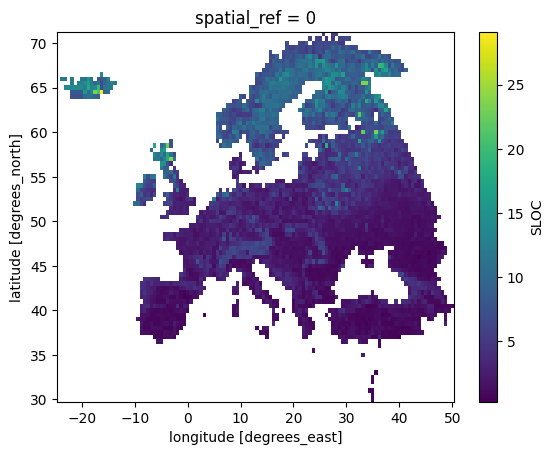

In [77]:
ds_eu['SLOC'].plot()

In [78]:
!pip3 -q install contextily



In [79]:
import contextily as cx

In [83]:
naming = {"SLOC":"Органическое вещество почвы",
        "SLCL": "Содержание глинистой фракции, %",
        'SLSI': "Содержание илистой фракции, %"}

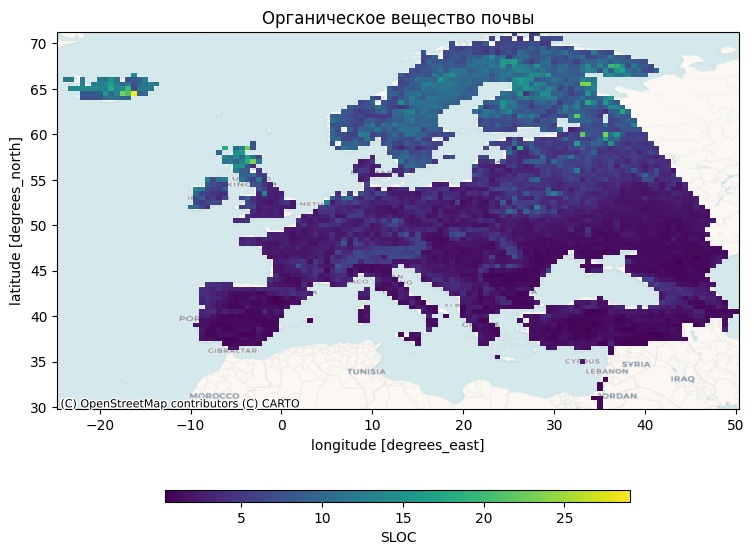

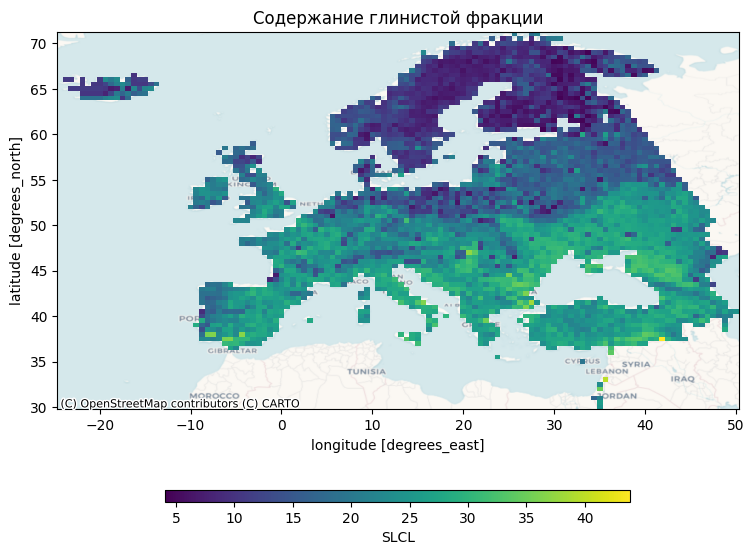

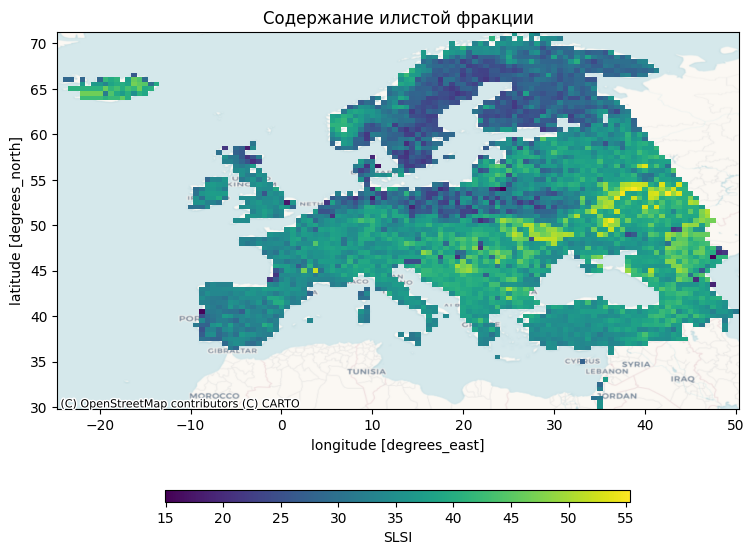

In [88]:
for soil_p in ["SLOC","SLCL",'SLSI']:
    fig, ax = plt.subplots(figsize=(10, 7))
    ds_eu[soil_p].plot(ax=ax, cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, 'aspect':40})
    ax.set_title(naming[soil_p])
    cx.add_basemap(ax, crs="epsg:4326",
                   source=cx.providers.CartoDB.Voyager)
    plt.savefig(f'./{soil_p}_map.png', dpi=300)
    # break

In [43]:
soil.layers[30].to_dict()['SLOC']


1.86

## 5. Sensitivity analysis run

| Name       | Parameter    | Range     | Unit | 
|------------|--------------|------------------------------------|-------------|
| SRGF       |     Root growth factor, soil only      |        0.0 to 1.0 | -  | 
| SBDM       |  Bulk density    | - | g/cm3  | 
| SLOC       |  Organic carbon  | - | g/cm3  | 
| SLCL       |  Clay    | - | g/cm3  | 
| SLSI       |  Silt    | - | g/cm3  | 
| SLHW       |  Soil pH in water    | - | g/cm3  | 


In [95]:
def get_bounds(soil, soil_cols):
    top_layer = soil.layers[30]
    lower = top_layer[soil_cols].astype(float) * 0.7
    upper = top_layer[soil_cols].astype(float) * 1.3
    upper['SRGF']=1.0
    while upper.SLSI + upper.SLSI > 100:
        upper.SLSI -= 1
        upper.SLSI -= 1
        print(upper.SLSI)
    assert upper.SLSI + upper.SLSI < 100, "Sum of Silt and Clay should be less then 100"
    
    lower = lower.round(4)
    upper = upper.round(4)
    bounds = [[low, up] for low, up in zip(lower, upper)]
    return bounds

def evaluate_soil(X: np.ndarray, soil, soil_cols: list, lon:float, lat:float):
    for i, key in enumerate(soil_cols):
        soil.layers[30][key] = X[i]
    soil.layers[30] = soil_sa.estimate_missing(soil.layers[30])
    crop_yield = dssat_runner.compute(crop_name = 'Soybean',
                     cultivar = '999991',
                    lat=lat,
                    lon=lon,
                    harvest = calendar['harvest_day'],
                    sowing = calendar['plant_day'],
                    soil = soil)
    return crop_yield


def rename(df):
    df = df.reset_index()
    df = df.rename(columns={'index':'soil_parameter'})
    return df

In [93]:

def conduct_sensitivity(lon=lon, lat=lat, soil=soil):
    soil_cols = ["SLOC","SLCL","SLSI"]
    
    # soil = soil_sa.get_soil_by_coords(lon=lon, lat=lat)
    # soil = soil_sa.aggregate_top_layer(soil)
    
    bounds = get_bounds(soil=soil, soil_cols=soil_cols)
    
    sp = ProblemSpec({
            "names": soil_cols,
            "groups": None,
            "bounds": bounds,
            "outputs": ["Y"],
        })
    
    sp.sample_sobol(32)
    
    
    Y = np.zeros([sp.samples.shape[0]])
    print(Y.shape)
    for i, X in tqdm_notebook(enumerate(sp.samples)):
        Y[i] = evaluate_soil(X, soil=soil,soil_cols=soil_cols, lon=lon, lat=lat)
    
    
    sp.set_results(Y)
    sp.analyze_sobol()
    total_Si, first_Si, second_Si = sp.to_df()
    return total_Si, first_Si, second_Si

In [96]:
lon=41.1
lat=49.9
point_weather = dssat_runner.ds_weather.sel(lon=lon, lat=lat, method="nearest")
if point_weather['T2M'].sum().values==0:
    container.append({"lon":lon, "lat":lat, "Yield":np.nan, 'Problem': "NO"})
calendar= agrocalendar.getCropCalendar(lon=lon, lat=lat, year = year)
if calendar['plant_day'] == 'NaN':
    container.append({"lon":lon, "lat":lat, "Yield":np.nan, 'Problem': "NO"})
try: 
    start = time.time()
    soil = soil_sa.get_soil_by_coords(lon=lon, lat=lat)
except KeyboardInterrupt as e:
    print('Interrupted')
    try:
        sys.exit(130)
    except SystemExit:
        os._exit(130)
except Exception as e:
    soil = soil_sa.get_soil_by_coords(lon=41.1, lat=49.9)


crop_yield = dssat_runner.compute(crop_name = 'Soybean',
                     cultivar = '999991',
                    lat=lat,
                    lon=lon,
                    harvest = calendar['harvest_day'],
                    sowing= calendar['plant_day'],
                    soil = soil)
total_Si, first_Si, second_Si = conduct_sensitivity(lon=lon, lat=lat, soil=soil)

/tmp/dssatrvhmbgoe created.
Static files copied to /tmp/dssatrvhmbgoe.
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  68 143  5772  1981   288   209   489    90     0   -99      0  242
/tmp/dssatrvhmbgoe and its content has been removed.
(256,)


/tmp/ipykernel_4055/229607129.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, X in tqdm_notebook(enumerate(sp.samples)):


0it [00:00, ?it/s]

/tmp/dssathfvrqxlg created.
Static files copied to /tmp/dssathfvrqxlg.
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  68 143  6003  2041   288   242   507   114     0   -99      0  249
/tmp/dssathfvrqxlg and its content has been removed.
/tmp/dssatrhewosjg created.
Static files copied to /tmp/dssatrhewosjg.
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  68 143  6003  2041   288   249   509   122     0   -99      0  232
/tmp/dssatrhewosjg and its content has been removed.
/tmp/dssathllorkyz created.
Static files copied to /tmp/dssathllorkyz.
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  68 143  6003  2041   288   243   504 

In [179]:
df_general = pd.DataFrame()
for lat in tqdm_notebook(to_compute_df.lat.values):
    for lon in to_compute_df.lon.values:
        point_weather = dssat_runner.ds_weather.sel(lon=lon, lat=lat, method="nearest")
        if point_weather['T2M'].sum().values==0:
            container.append({"lon":lon, "lat":lat, "Yield":np.nan, 'Problem': "NO"})
            continue
        calendar= agrocalendar.getCropCalendar(lon=lon, lat=lat, year = year)
        if calendar['plant_day'] == 'NaN':
            container.append({"lon":lon, "lat":lat, "Yield":np.nan, 'Problem': "NO"})
            continue
        try: 
            start = time.time()
            soil = soil_sa.get_soil_by_coords(lon=lon, lat=lat)
        except KeyboardInterrupt as e:
            print('Interrupted')
            try:
                sys.exit(130)
            except SystemExit:
                os._exit(130)
        except Exception as e:
            soil = soil_sa.get_soil_by_coords(lon=41.1, lat=49.9)
    

        crop_yield = dssat_runner.compute(crop_name = 'Soybean',
                             cultivar = '999991',
                            lat=lat,
                            lon=lon,
                            harvest = calendar['harvest_day'],
                            sowing= calendar['plant_day'],
                            soil = soil)
        total_Si, first_Si, second_Si = conduct_sensitivity(lon=lon, lat=lat, soil=soil)
        first_Si = first_Si.reset_index().rename(columns={'index':'soil'})
        total_Si = total_Si.reset_index(drop=True)
        second_Si = second_Si.reset_index().rename(columns={'index':'soil_interaction'})
        df_rep = pd.concat([first_Si, total_Si, second_Si], axis=1)
        df_rep['lon']=lon
        df_rep['lat']=lat
        df_general = pd.concat([df_general, df_rep])
        df_general.to_csv(os.path.splitext(fname)[0]+'_result_Sobol.csv')
        container.append({"lon":lon, "lat":lat, "Yield":crop_yield, 'Problem': "NO"})
        df_y = pd.DataFrame(container)
        df_y.to_csv(os.path.splitext(fname)[0]+'_result_yield.csv')

/tmp/ipykernel_16877/881549657.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for lat in tqdm_notebook(to_compute_df.lat.values):


  0%|          | 0/365 [00:00<?, ?it/s]

/tmp/dssatmrpvfykc created.
Static files copied to /tmp/dssatmrpvfykc.
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  36 105  4296  1562   253   164   466    84     0   -99      0  384
/tmp/dssatmrpvfykc and its content has been removed.
51.261
49.261
(160,)


/tmp/ipykernel_16877/2052774989.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, X in tqdm_notebook(enumerate(sp.samples)):


0it [00:00, ?it/s]

/tmp/dssatgtshpexh created.
Static files copied to /tmp/dssatgtshpexh.
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  36 105  4297  1562   253   155   475    70     0   -99      0  387
/tmp/dssatgtshpexh and its content has been removed.
/tmp/dssatsjwrnpjn created.
Static files copied to /tmp/dssatsjwrnpjn.
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  36 105  4297  1562   253   166   485    74     0   -99      0  387
/tmp/dssatsjwrnpjn and its content has been removed.
/tmp/dssatstbrcsgo created.
Static files copied to /tmp/dssatstbrcsgo.
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SB   1  36 105  4290  1562   253   168   481 


KeyboardInterrupt



In [43]:
soil = soil_sa.get_soil_by_coords(lon=41.1, lat=49.9)

## End